In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam, SGD
from tqdm import tqdm
import os

from utils import Encoder, Decoder, awgn, ser_mqam_awgn

In [2]:
CONFIG_TRAIN = {
    "M": 16,  # Number of constellation points
    "flag_train_model": True,  # Flag to control training
    "training_snr": 12,  # Training SNR (dB)
    "best_encoder_path": "./model/ae_siso_awgn_16qam_best_encoder.pth",  # Path to save the best encoder
    "best_decoder_path": "./model/ae_siso_awgn_16qam_best_decoder_3.pth",  # Path to save the best decoder
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
encoder = Encoder([CONFIG_TRAIN["M"], 10, 10, 2]).to(device)
decoder = Decoder([2, 20, 20, CONFIG_TRAIN["M"]]).to(device)

In [4]:
checkpoint = torch.load(CONFIG_TRAIN["best_encoder_path"], map_location=device)
encoder.load_state_dict(checkpoint)

<All keys matched successfully>

In [5]:
def save_decoder(decoder, loss, optimizer):
    """
    Save the model to a file.
    - decoder: the decoder model
    - loss: the loss history
    - optimizer: the optimizer
    - model_type: "latest"(default) or "best"
    """
    torch.save(
        {
            "Decoder": decoder.state_dict(),
            "loss": loss,
            "optimizer": optimizer.state_dict(),
        },
        CONFIG_TRAIN["best_decoder_path"],
    )


def early_stopping(loss_hist, patience=5):
    """
    Check if the training should be stopped early.
    - loss_hist: list of loss values
    - patience: number of epochs to wait before stopping
    """

    if len(loss_hist) > patience:
        if all(
            x > loss_hist[-1] for x in loss_hist[-(patience + 1) :]
        ):  # if the last patience losses are decreasing
            return True
    return False


def train_decoder(decoder, optimizer, iterations, loss_hist, batch_size, messages, rx):
    criterion = nn.NLLLoss()  # negative log likelihood loss
    best_loss = float("inf")  # Initialize the best loss to infinity
    try:
        for iterator in tqdm(
            range(len(loss_hist), iterations), desc="training process"
        ):
            start_index = int(iterator * batch_size)
            end_index = int((iterator + 1) * batch_size - 1)
            messages_batch = messages[start_index:end_index]
            rx_batch = rx[iterator * batch_size : (iterator + 1) * batch_size - 1]
            y_pred = decoder(rx_batch)
            loss = criterion(y_pred, messages_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())

            if loss.item() < best_loss:
                best_loss = loss.item()
                save_decoder(decoder, loss_hist, optimizer)

            if early_stopping(loss_hist):
                print("Early stopping")
                break
        print("Training complete")

    except KeyboardInterrupt:
        save_decoder(decoder, loss_hist, optimizer)
        print("Training interrupted")

    save_decoder(decoder, loss_hist, optimizer)
    # Plot the loss
    plt.semilogy(loss_hist)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()

Training from scratch


/var/folders/x4/5z4_pt2n7m12cdcvjm0d6cjw0000gn/T/ipykernel_13660/4288356182.py:32: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  rx = torch.from_numpy(rx).to(device)
training process: 100%|██████████| 1000/1000 [00:03<00:00, 331.59it/s]


Training complete


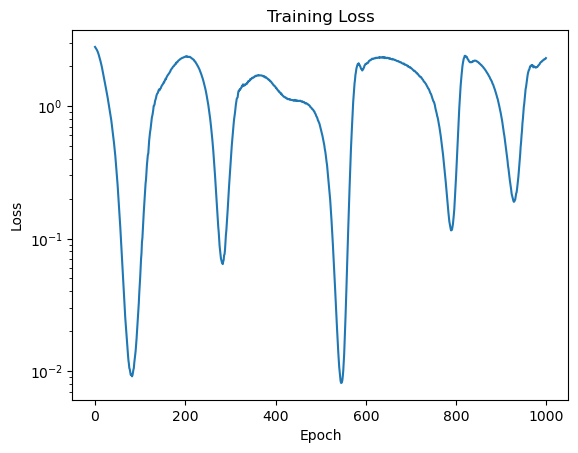

In [6]:
if CONFIG_TRAIN["flag_train_model"]:
    # check if there is a checkpoint to resume training
    if os.path.exists(CONFIG_TRAIN["best_decoder_path"]):
        checkpoint = torch.load(CONFIG_TRAIN["best_decoder_path"], map_location=device)
        # load the model, optimizer a loss history
        decoder.load_state_dict(checkpoint["Decoder"])

    parameters = list(decoder.parameters())
    optimizer = Adam(parameters, lr=0.01)

    if os.path.exists(CONFIG_TRAIN["best_decoder_path"]):
        # optimizer.load_state_dict(checkpoint["optimizer"])
        loss_hist = checkpoint["loss"]
        print(f"Resuming training from iterator {len(loss_hist)}")
    else:
        loss_hist = []
        print("Training from scratch")

    num_messages = int(1e7)  # Number of messages to use for training (batch size)
    messages = torch.randint(0, 16, size=(num_messages,), device=device)
    one_hot = F.one_hot(messages, 16).float()
    tx = encoder(one_hot)
    # write tx to a binary file
    tx = tx.detach().numpy()
    with open("./file/tx.dat", "wb") as f:
        f.write(tx.tobytes())
    # run channel.py to generate rx
    os.system("python3 ./gnuradio/frequency_selective_fading_model.py")
    # read rx from a binary file
    with open("./file/rx3.dat", "rb") as f:
        rx = np.frombuffer(f.read(), dtype=np.float32)
    rx = torch.from_numpy(rx).to(device)
    rx = rx.view(-1, 2)

    iterations = int(1e3)  # Total number of epochs to train
    if iterations > len(loss_hist):
        train_decoder(decoder, optimizer, iterations, loss_hist, int(1e4), messages, rx)
    else:
        print("epochs already completed")
else:
    # check if there is a checkpoint to load the model
    if os.path.exists(CONFIG_TRAIN["best_decoder_path"]):
        checkpoint = torch.load(CONFIG_TRAIN["best_decoder_path"], map_location=device)
        decoder.load_state_dict(checkpoint["Decoder"])
        print("Model loaded. Training iterator: ", len(checkpoint["loss"]))
    else:
        print(
            "Model not found, please set flag_train_model to True and train the model"
        )
        exit(1)

In [7]:
# load the best decoder
checkpoint = torch.load(CONFIG_TRAIN["best_decoder_path"], map_location=device)
decoder.load_state_dict(checkpoint["Decoder"])

# Calculate the symbol error rate
num_messages_test = int(1e4)  # Number of messages to use for training (batch size)
messages_test = torch.randint(0, 16, size=(num_messages_test,), device=device)
one_hot_test = F.one_hot(messages_test, 16).float()
tx_test = encoder(one_hot_test)
# write tx to a binary file
tx_test = tx_test.detach().numpy()
with open("./file/tx.dat", "wb") as f:
    f.write(tx_test.tobytes())
# run channel.py to generate rx
os.system("python3 ./gnuradio/frequency_selective_fading_model.py")
# read rx from a binary file
with open("./file/rx3.dat", "rb") as f:
    rx_test = np.frombuffer(f.read(), dtype=np.float32)
rx_test = torch.from_numpy(rx_test).to(device)
rx_test = rx_test.view(-1, 2)
y_pred_one_hot_test = decoder(rx_test)
_, y_pred_test = torch.max(y_pred_one_hot_test, 1)
# Calculate and print the symbol error rate
ser = torch.mean((y_pred_test != messages_test).float()).item()
print(f"Symbol Error Rate: {ser}")

Symbol Error Rate: 0.9869999885559082
